<div style="display: flex; justify-content: space-between; align-items: center;">
    <div>
        <h1>Assignment #2</h1>
    </div>
    <div style="text-align: right;">
        <strong>👤 Submitted by:</strong> Sana Ullah Khan<br>
        <strong>📧 Email:</strong> <a href="mailto:sanaa.nahk@gmail.com">sanaa.nahk@gmail.com</a>
    </div>
</div>


#### verify if TensorFlow is correctly detecting GPU and also double-check my current working directory.

In [37]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.experimental.list_physical_devices())
print(tf.test.is_built_with_cuda() )

2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [4]:
%pwd #working Dir

'/mnt/d/Courses/Dice AI/Assignment_02'

<div align="center" style="font-size:30px;">

# Assignment 2

<hr style="border:2px solid black"> </hr>
</div>


# Libraries used

In [5]:
#for all tasks
import os
import matplotlib.pyplot as plt
import numpy as np
import helper
import time
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #ignore some warnings! to keep the logs and code clean!
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.data import AUTOTUNE
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import euclidean_distances

<div align="center">

# <u><b>Task 1: (marks=15)</b></u>

</div>

Implement a basic CNN model from scratch using TensorFlow for image classification. In our dataset, we have 3 classes of digits which are 0, 1, and 2.

**What you need to do is:**

* 1. **Split the dataset into training and validation set.** 80% for training and the remaining 20% for validation. You should do this split in code. You are only provided with a single folder which is having all the 3 classes. Each sub-folder in the Hand_written_digits folder is considered a separate class/category by the TensorFlow. TensorFlow allows you to do the split. Check TensorFlow official documentation to see how it is done. Images in the dataset are grayscale of size (100x100) pixel. The dataset provided to you is in the following format:
   - Hand_written_digits
     - 0_digits
     - 1_digits
     - 2_digits


> <span style="color:blue; font-size:110%; font-family:'Century Gothic'; font-weight:bold;">
This section prepares the data for training and validation, ensuring consistency with the same seed 42 (i alwasy wonder why everyone use 42) for reproducibility.

<span style="color:blue; font-size:110%; font-family:'Century Gothic'; font-weight:bold;">
    
- hyperparameters such as `batch_size`, `img_height`, and `img_width` are defined. 
- The dataset is split into `80% for training` and `20% for validation`.
- Gray scale images of size (100x100) pixels are used. 
- For both training and validation datasets, the function `image_dataset_from_directory()` is utilized with specified parameters, including the `color mode`, `validation split`, `seed value`, `image size`, and `batch size`. 




In [38]:
# Define data dir
data_dir = r"/mnt/d/Courses/Dice AI/Assignment_02/data_assign_2/hand_written_digits"

In [4]:
# Define hyperparameters
batch_size = 256 # Larger batch size is better for my GPU. It processes tasks in parallel, which means it can do more at once and save time.
img_height = 100 #given
img_width = 100 #given

In [42]:
# split 80% for training and the remaining 20% for validation.

train_ds = image_dataset_from_directory(
    data_dir,
    color_mode='grayscale',       # Images in the dataset are gray scale of size (100x100) pixel.
    validation_split=0.2,         #20% for validation
    subset="training",
    seed=42,                      #the lucky seed number 42
    image_size=(img_height, img_width),
    batch_size=batch_size)
print("========================================")

val_ds = image_dataset_from_directory(
    data_dir,
    color_mode='grayscale',       # same gray scale data
    validation_split=0.2,
    subset="validation",
    seed=42,                      #same seed as above
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 4658 files belonging to 3 classes.
Using 3727 files for training.
Found 4658 files belonging to 3 classes.
Using 931 files for validation.


In [33]:
3727+931 #cross check

4658

In [43]:
print(f"training data set calss labels are : {train_ds.class_names}")

training data set calss labels are : ['0_digits', '1_digits', '2_digits']


In [44]:
print(f"validation data set calss labels are : {val_ds.class_names}")

validation data set calss labels are : ['0_digits', '1_digits', '2_digits']


* 2. **Train model on the provided dataset.** Do the data augmentation suitable for the dataset provided. Be careful while doing the augmentation as all the augmentations are not suitable for our dataset like doing the vertical flip or horizontal flip on digit 2 changes it to something else.

Train the model on the provided hand-written digits dataset and report the accuracy achieved after 10 epochs of training. You can increase the number of epochs as per your choice but be careful of model overfitting. This task will be marked based on validation accuracy so do play around with the model architecture to achieve the best possible accuracy.

*Following is the model architecture. You can change the model architecture as per your creativity.*


<div align="center">
  <img src="cnn.jpeg" alt="Description of image">
</div>


> <span style="color:blue; font-size:110%; font-family:'Century Gothic'; font-weight:bold;">
In this section, I'm configuring a data augmentation pipeline for image data using TensorFlow. The pipeline includes:

<span style="color:blue; font-size:110%; font-family:'Century Gothic'; font-weight:bold;">
    
- Rescaling pixel values to a range between 0 and 1
- Random rotation (up to 20% angle) and zooming (up to 10% zoom)
- Random horizontal and vertical translation (up to 10% in each direction)
- Random contrast adjustment (up to 10% increase or decrease)

> These transformations are applied to the training dataset `train_ds` using the `map` function, active only during training, and optimized with `tf.data.AUTOTUNE` for efficiency.
</span>



In [45]:
# Define augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255), #b/t zero and one
    tf.keras.layers.RandomRotation(0.2),  # rotation max 20%
    tf.keras.layers.RandomZoom(0.1),  # zoom max 10%
    tf.keras.layers.RandomTranslation(0.1, 0.1),  # transalte, 10% horizontal and 10% verticl
    tf.keras.layers.RandomContrast(0.1)])  # change contrast max 10% plus or minus. 

### NOTE #####
# i am using Tf version 2.15.0, these augmentation functions were part of the experimental module  in previous versions.

In [46]:
train_ds_augmented = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    # x =input data, y = corresponding label, 
    # training=True argument ensures that the augmentation is only active during training different fro each epoch.  
    
    # tf.data.AUTOTUNE allows TensorFlow to automatically adjust the number of threads dynamically,
    # ...based on the current system conditions.


> <span style="color:blue; font-size:110%; font-family:'Century Gothic'; font-weight:bold;">
applying only `normalization` on velidation set as validation and test data should remain unaltered to accurately assess model performance on real-world data.

In [47]:
#normalization on vel. dataset

data_augmentation_val = tf.keras.Sequential([tf.keras.layers.Rescaling(1./255)]) 

val_ds = val_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

> <span style="color:blue; font-size:110%; font-family:'Century Gothic'; font-weight:bold;">
defining CNN  which consist of two convolutional layers with 5x5 filters and 'valid' (no) padding. After each convolutional layer, max-pooling is applied to reduce dimensions. The flattened layer converts the 2D feature maps into a 1D vector, followed by two fully connected layers for classification. 

In [48]:
model = Sequential()
#l1
model.add(Conv2D(64, (5, 5), activation='relu', padding='valid', input_shape=(img_height, img_width, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
#L2
model.add(Conv2D(32, (5, 5), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten and funlly connected 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))  # Final

In [49]:
#Compile the Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [50]:
# Train the Model
epochs = 20
history = model.fit(
    train_ds_augmented,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
15/15 [==============================] - 9s 233ms/step - loss: 1.0398 - accuracy: 0.4915 - val_loss: 0.5636 - val_accuracy: 0.7777
Epoch 2/20
15/15 [==============================] - 7s 260ms/step - loss: 0.5311 - accuracy: 0.7867 - val_loss: 0.3521 - val_accuracy: 0.8464
Epoch 3/20
15/15 [==============================] - 7s 231ms/step - loss: 0.3520 - accuracy: 0.8677 - val_loss: 0.2763 - val_accuracy: 0.8947
Epoch 4/20
15/15 [==============================] - 6s 226ms/step - loss: 0.2910 - accuracy: 0.8943 - val_loss: 0.2496 - val_accuracy: 0.9066
Epoch 5/20
15/15 [==============================] - 7s 223ms/step - loss: 0.2386 - accuracy: 0.9117 - val_loss: 0.1878 - val_accuracy: 0.9323
Epoch 6/20
15/15 [==============================] - 6s 227ms/step - loss: 0.2121 - accuracy: 0.9276 - val_loss: 0.1818 - val_accuracy: 0.9270
Epoch 7/20
15/15 [==============================] - 6s 224ms/step - loss: 0.1867 - accuracy: 0.9308 - val_loss: 0.1376 - val_accuracy: 0.9431
Epoch 

In [51]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")

4/4 [==============================] - 2s 41ms/step - loss: 0.0559 - accuracy: 0.9774
Validation loss: 0.05585062503814697
Validation accuracy: 0.9774436354637146


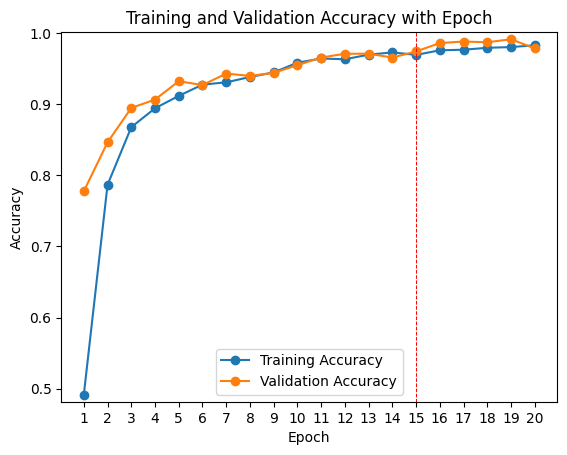

In [53]:
# Usage example:
helper.plot_accuracy(history, 15, 'Training and Validation Accuracy with Epoch')

<span style="color:blue; font-size:150%; font-family:'Century Gothic';"> Twenty epochs have been applied to the above-defined model. As a general concept, repeatedly going through a book enhances understanding, and the same applies to neural networks. More epochs tend to improve accuracy, but they can also lead to overfitting. I trained the model for 20 epochs, achieving $97.7$% accuracy, which sounds impressive. <span style="color:blue; font-size:100%; font-family:'Century Gothic';  text-decoration: underline; background-color: yellow;">
However, the optimal number of epochs for this model should be between 11 or 15.</span>
    
* <span style="color:blue; font-size:150%; font-family:'Century Gothic';"> 
As a general guideline, the optimal number of epochs to avoid overfitting would be around where the validation accuracy plateaus or starts to decrease while the training accuracy continues to increase.


<div align="center">

# <u><b>Task 2: (marks=15)</b></u>

</div>

Now this time do Task 1 again by fine-tuning the pre-trained model of your choice. Contents of week 6 and week 7 are focused on the concept of transfer learning so the main objective of this task is to solidify and reinforce your core concepts of transfer learning and how to fine-tune a pre-trained model trained on different dataset for your own custom dataset. Observe the accuracy of the model and compare it with the accuracy of the model in task 1.


*  <span style="color:blue; font-size:150%; font-family:'Century Gothic'; font-weight:bold;"> 2.1 Resize and Rescale </span>
> <span style="color:blue; font-size:110%; font-family:'Century Gothic'; font-weight:bold;">
I'll fine-tune the "mobilenetv2_1" model for transfer learning. This model was originally trained on the ImageNet dataset, which is quite different from our handwritten images dataset. Additionally, the model expects RGB images of size 224x224 pixels, but our data is 100x100 and grayscale. So, first, we'll resize our images to match the required input size.

In [69]:
# Define preprocessing for training and validation data
preprocessing = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.Resizing(224, 224),  #mobilenet expects this shape!!!!
    layers.Lambda(lambda x: tf.tile(x, [1, 1, 1, 3]))  # grayscale to RGB as our data is not RGB which is model requirment,
])

In [85]:
# Load and preprocess the training dataset
train_ds = image_dataset_from_directory(
    data_dir,
    color_mode='grayscale',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size).map(lambda x, y: (preprocessing(x), y), num_parallel_calls=tf.data.AUTOTUNE) #processing !! gr to RGB and scaling

print("===========PROCESSED===================")
val_ds = image_dataset_from_directory(
    data_dir,
    color_mode='grayscale',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
).map(lambda x, y: (preprocessing(x), y), num_parallel_calls=tf.data.AUTOTUNE) #same as fro training !

Found 4658 files belonging to 3 classes.
Using 3727 files for training.
===========PROCESSED===================
Found 4658 files belonging to 3 classes.
Using 931 files for validation.


In [88]:
for images, labels in val_ds.take(1):
    print("Image shape val: ", images.shape) #yes its  RGB now !

for images, labels in train_ds.take(1):
    print("Image shape train: ", images.shape) # and also in 224x224

Image shape val:  (256, 224, 224, 3)
Image shape train:  (256, 224, 224, 3)


*  <span style="color:blue; font-size:150%; font-family:'Century Gothic'; font-weight:bold;"> 2.2 Augmentation </span>
> <span style="color:blue; font-size:110%; font-family:'Century Gothic'; font-weight:bold;">
Augmentation will be applied exclusively to the training dataset, and you can find detailed steps outlined in task 1.

In [89]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),  # rotation max 20%
    tf.keras.layers.RandomZoom(0.1),  # zoom max 10%
    tf.keras.layers.RandomTranslation(0.1, 0.1),  # transalte, 10% horizontal and 10% verticl
    tf.keras.layers.RandomContrast(0.1)]) 

#it was alredy defined in task 1 but .. again for better code understanding !

# Apply data augmentation only to the training dataset
train_ds_augmented = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

*  <span style="color:blue; font-size:150%; font-family:'Century Gothic'; font-weight:bold;"> 2.3 Base model </span>
> <span style="color:blue; font-size:110%; font-family:'Century Gothic'; font-weight:bold;">
Let's download and fine-tune the MobileNetV2 base model. Since our digit dataset differs significantly from the ImageNet dataset used to train MobileNet, we'll need to take specific steps. We'll remove a substantial portion of the pre-trained layers at the network's beginning. We'll also initialize the weights of the new fully connected layer with random values while keeping the weights of all pre-trained layers fixed.


In [90]:
# Load the base MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),include_top=False, weights='imagenet')
base_model.trainable = False #Freeze the base model


*  <span style="color:blue; font-size:150%; font-family:'Century Gothic'; font-weight:bold;"> 2.4 Tailor the model </span>
> <span style="color:blue; font-size:110%; font-family:'Century Gothic'; font-weight:bold;">
Using pre-trained MobileNetV2 for transfer learning. Added custom classification layers for 3 categories. Base model frozen for training.

In [91]:
# Create the new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  #regularization
    layers.Dense(3, activation='softmax')  #Output
])

In [92]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2422339 (9.24 MB)
Trainable params: 164

In [93]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [94]:
epochs = 20  
history = model.fit(
    train_ds_augmented,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
15/15 [==============================] - 15s 326ms/step - loss: 0.3403 - accuracy: 0.8656 - val_loss: 0.0428 - val_accuracy: 0.9882
Epoch 2/20
15/15 [==============================] - 11s 308ms/step - loss: 0.0814 - accuracy: 0.9748 - val_loss: 0.0360 - val_accuracy: 0.9871
Epoch 3/20
15/15 [==============================] - 10s 295ms/step - loss: 0.0673 - accuracy: 0.9796 - val_loss: 0.0320 - val_accuracy: 0.9871
Epoch 4/20
15/15 [==============================] - 10s 298ms/step - loss: 0.0611 - accuracy: 0.9812 - val_loss: 0.0264 - val_accuracy: 0.9914
Epoch 5/20
15/15 [==============================] - 11s 295ms/step - loss: 0.0449 - accuracy: 0.9858 - val_loss: 0.0230 - val_accuracy: 0.9936
Epoch 6/20
15/15 [==============================] - 11s 302ms/step - loss: 0.0471 - accuracy: 0.9869 - val_loss: 0.0200 - val_accuracy: 0.9925
Epoch 7/20
15/15 [==============================] - 11s 316ms/step - loss: 0.0432 - accuracy: 0.9855 - val_loss: 0.0254 - val_accuracy: 0.9903

*  <span style="color:blue; font-size:150%; font-family:'Century Gothic'; font-weight:bold;"> 2.5 Evaluate the model </span>
> <span style="color:blue; font-size:110%; font-family:'Century Gothic'; font-weight:bold;">
Trained for 20 epochs and plotted training/validation accuracy.

In [95]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")

4/4 [==============================] - 2s 104ms/step - loss: 0.0124 - accuracy: 0.9936
Validation loss: 0.012426209636032581
Validation accuracy: 0.9935553073883057


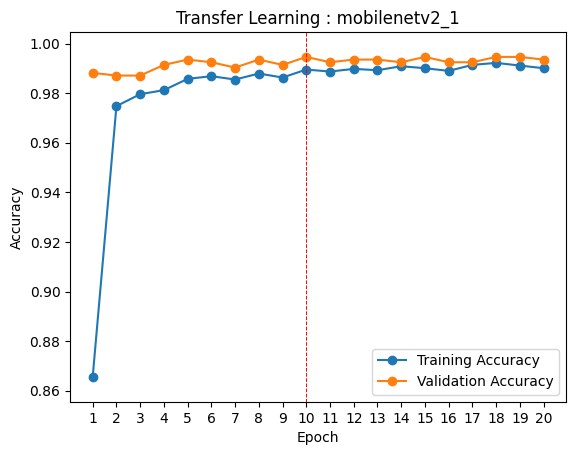

In [100]:
helper.plot_accuracy(history, 10, 'Transfer Learning : mobilenetv2_1')

<span style="color:blue; font-size:150%; font-family:'Century Gothic';"> Great! The model achieved higher accuracy, learned quickly, and maintained a consistent gap between training and validation accuracy, indicating no overfitting. It reached an accuracy of 99.3%. The graph suggests that 10 epochs are sufficient for optimal accuracy </span>
    


*  <span style="color:blue; font-size:150%; font-family:'Century Gothic'; font-weight:bold;"> 2.6 Save the model </span>
> <span style="color:blue; font-size:110%; font-family:'Century Gothic'; font-weight:bold;">
Lastly, preserve the model for future purposes. Given its impressive accuracy in recognizing handwritten digits, I have named it the  <span style="color:blue; font-size:100%; font-family:'Century Gothic';  text-decoration: underline; background-color: yellow;"> DigitDoodleNet.

In [103]:
modelName = "DigitDoodleNet"
model_save_path = os.path.join(data_dir, modelName)
model.save(model_save_path)

INFO:tensorflow:Assets written to: /mnt/d/Courses/Dice AI/Assignment_02/data_assign_2/hand_written_digits/DigitDoodleNet/assets


INFO:tensorflow:Assets written to: /mnt/d/Courses/Dice AI/Assignment_02/data_assign_2/hand_written_digits/DigitDoodleNet/assets


<div align="center">

# <u><b>Task 3: (marks=20)</b></u>

</div>

Now that you understand the importance of CNNs in image searching and retrieval, it's time to apply your knowledge and create your first image retrieval system. Follow the instructions below to complete this assignment:

* <h4> 1.  Write a Python program that allows users to select a query image from folder "query_images" and retrieve the top N similar images from a local folder named "images_database". Put N=4 for this task so the system must spit out 4 similar images from the given folder closely similar to your query image. Your program should use a pre-trained CNN model (e.g., VGG16 or ResNet) for feature extraction and a similarity metric (e.g., Euclidean distance) for retrieval.</h4>

*  <span style="color:blue; font-size:150%; font-family:'Century Gothic'; font-weight:bold;"> 3.1 Define directoriese </span>
> <span style="color:blue; font-size:110%; font-family:'Century Gothic'; font-weight:bold;">
defined directory paths for two main folders.

In [19]:
# Define the data directory and folders
data_dir = r"/mnt/d/Courses/Dice AI/Assignment_02/data_assign_2"
database_dir = os.path.join(data_dir, 'images_retreival_local_database')
query_dir = os.path.join(data_dir, 'query_images')

*  <span style="color:blue; font-size:150%; font-family:'Century Gothic'; font-weight:bold;"> 3.2 Loading pre trained model </span>
> <span style="color:blue; font-size:110%; font-family:'Century Gothic'; font-weight:bold;">
 loading a pre-trained `ResNet model` from the 'imagenet' dataset and removes the top classification layer. then creating a new model that extracts features from images using the ResNet architecture.

In [20]:
# Load a pre-trained ResNet model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=True)
# We'll use the last but one layer as feature extractor
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

*  <span style="color:blue; font-size:150%; font-family:'Century Gothic'; font-weight:bold;"> 3.3 Define feature extraction </span>
`extract_features(img_path, model)`
> <span style="color:blue; font-size:110%; font-family:'Century Gothic'; font-weight:bold;">
This function extracts features from an image using a pre-trained model. It loads and resizes the image, converts it to a numpy array, and then adds a batch dimension. After preprocessing, the model is applied to the image, and the resulting features are flattened and normalized for consistent comparisons.

In [24]:
# Function to extract features from an image
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224)) #load imagea nd resize 20 Resnet50's input size! explained in task 2!
    img_array = image.img_to_array(img) #convert imae to np array
    expanded_img_array = np.expand_dims(img_array, axis=0) # although we resized but we still need to exapnd to add teh batch dimenssion  as model expected..
                                                            #.. here the batch dim. is  1 and axis 0 measn it should be added at begining. !! this tookme 3 hours to understadn by the way 
    preprocessed_img = preprocess_input(expanded_img_array) #
    features = model.predict(preprocessed_img) #apply defined model on above array
    flattened_features = features.flatten() #flatten...
    normalized_features = flattened_features / np.linalg.norm(flattened_features) #divide each element from 1D array (flatten) by the euclidean norm (length)...
                                                                                #useful in comparing feature vectors in a way that is independent of their magnitude. just like usual nomalization
    return normalized_features

*  <span style="color:blue; font-size:150%; font-family:'Century Gothic'; font-weight:bold;"> 3.4 Image Retrieval and Similarity Visualization  </span>`def retrieve_images(query_image_name, model, database_dir, N=4):`
> <span style="color:blue; font-size:110%; font-family:'Century Gothic'; font-weight:bold;">
This function retrieves similar images from a local database based on a query image. It calculates the similarity between the query image and images in the database using extracted features. It then displays the query image and the top N similar images using Matplotlib.

In [32]:
# refrences:
#https://www.youtube.com/watch?v=aACebENHlrs

# Function to retrieve images
def retrieve_images(query_image_name, model, database_dir, N=4):
    query_image_path = os.path.join(query_dir, query_image_name) #query path
    query_feature = extract_features(query_image_path, model) #apply above defined function of features
    database_features = {} #dict to hold infomration aboutl images

    for img_name in os.listdir(database_dir): #loop in whole dir. and get fetures save them in dict  key = img name and value = features.
        img_path = os.path.join(database_dir, img_name)
        database_features[img_name] = extract_features(img_path, model) #{img name: features}

    distances = {}  #euclidean distance b/w input imag and other images in db dir.
    for img_name, img_feature in database_features.items():
        distances[img_name] = euclidean_distances([query_feature], [img_feature]) # sam as above {img name : euc. dist.}

    sorted_distances = sorted(distances.items(), key=lambda x: x[1]) #sort them to get top n
    top_n_images = sorted_distances[:N] # top 4... 

    #display time 

    ##### refrecne fro below work =    https://github.com/Sanaullah-nahk/Learning_libraries/blob/main/Matplotlib.ipynb

    fig, axes = plt.subplots(1, N+1, figsize=(15, 6))
    query_img = image.load_img(query_image_path)
    axes[0].imshow(query_img)
    axes[0].set_title("Query Image" , fontsize=20, color='red')
    axes[0].axis('off')
    for i, (img_name, _) in enumerate(top_n_images, start=1):
        img_path = os.path.join(database_dir, img_name)
        similar_img = image.load_img(img_path)
        axes[i].imshow(similar_img)
        axes[i].set_title(f"Similar Image {i}", fontsize=18, color='blue')
        axes[i].axis('off')
    plt.tight_layout()

*  <span style="color:blue; font-size:150%; font-family:'Century Gothic'; font-weight:bold;"> 3.5 Calling the main Function </span>
> <span style="color:blue; font-size:110%; font-family:'Century Gothic'; font-weight:bold;">
Calling the main function is pretty simple... you only need to provide the query image filename from the query image folder, and it will display the top 4 similar images from the database folder.

1/1 [==============================] - 0s 29ms/step


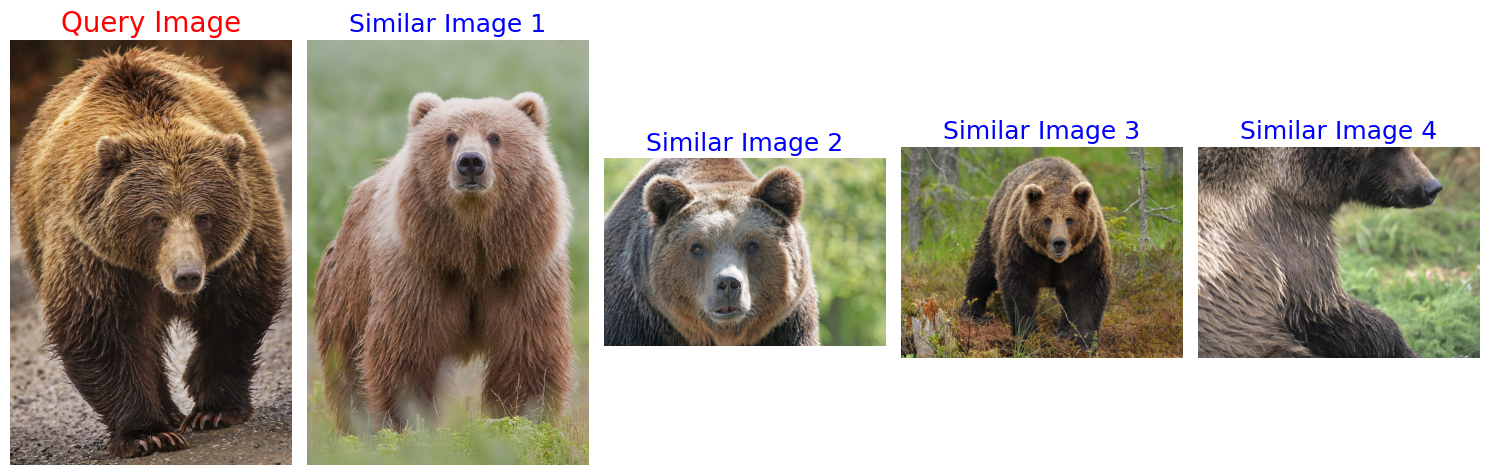

In [33]:
query_image_name = '039b2ae790.jpg'
retrieve_images(query_image_name, model, database_dir)

1/1 [==============================] - 0s 27ms/step


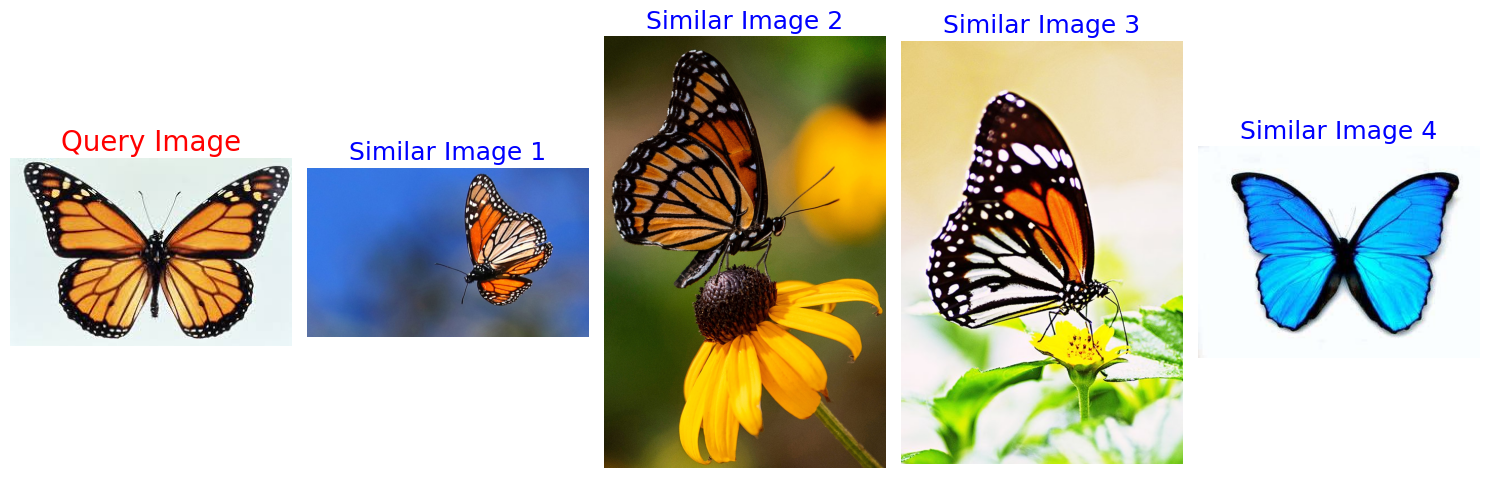

In [34]:
# Input: Image name in the 'query_images' folder
query_image_name = '3513bc5551.jpg'

# Call the function to retrieve and display similar images
retrieve_images(query_image_name, model, database_dir)

* <h4> 2. Ensure that your program can handle images in various formats (e.g., JPG, PNG, JPEG).</h4>

> <span style="color:blue; font-size:110%; font-family:'Century Gothic'; font-weight:bold;">
in section 3.3 (Define feature extraction), the image.load_img function from the Keras library is capable of handling various image formats, including JPG, PNG, and JPEG.